In [1]:
#Active environment should be cgcnn_matai
!conda info | grep 'cgcnn_matai'

     active environment : cgcnn_matai
    active env location : /home/hassan101/anaconda3/envs/cgcnn_matai


In [2]:
import pandas as pd
import json
import boto3
import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import get_vectors
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'01-Data preparation/'))
from helper_funcs import add_anions_v2

import torch
from openTSNE import TSNE as otsne
from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE

In [3]:
import os
MAPI_KEY = os.environ['MAPI_KEY']
aws_akid = os.environ['AWS_KID']
aws_sak = os.environ['AWS_AK']

In [4]:
#Setting up pymatgen
import pymatgen
from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
mpr = MPRester(MAPI_KEY)

/home/hassan101/anaconda3/envs/cgcnn_matai/lib/python3.11/site-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


In [5]:
res_s3 = boto3.resource('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak)
client_s3 = boto3.client('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak) 

bucket_name = 'datasets-cgcnn'

def load_from_s3(file_path):
    response = client_s3.get_object(Bucket=bucket_name, Key=file_path).get("Body")
    print("FILE LOADED")
    return response

#Loading data
df_ds1 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds1.xlsx').read())).dropna(how='any').reset_index(drop=True)
df_ds2 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds2.xlsx').read())).dropna(how='any').reset_index(drop=True)
df_ds3 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds3.xlsx').read())).dropna(how='any').reset_index(drop=True)

FILE LOADED
FILE LOADED
FILE LOADED


In [6]:
#Pretrained base model
m1_main_path = os.path.join(os.path.dirname(os.getcwd()),'02-MLdev/saved_models/m1_150-200epochs.pth.tar')

#Pretrained target model
m2_main_path = os.path.join(os.path.dirname(os.getcwd()),'02-MLdev/saved_models/m2-rsX/m2-rsX_50epoch.pth.tar') 

path_to_cif_folder = os.path.join(os.path.dirname(os.getcwd()),'master_files/cif_master')
path_to_init_file = os.path.join(os.path.dirname(os.getcwd()),'master_files/cgcnn_atom_init/atom_init.json')

In [7]:
def populate(input_dataset):

    input_dataset = input_dataset.copy()
    
    #Add predicted band gaps
    df_pred, crystal_features = get_vectors.predict(mpids_pred = input_dataset[['mpids']],
                                        model_pred = torch.load(m2_main_path), 
                                        cif_folder = path_to_cif_folder,   
                                        init_file = path_to_init_file, 
                                        max_nbrs = 14, 
                                        radius = 7)
    input_dataset = input_dataset.join(df_pred['pred']) 
    print('MAE_val_main=',mean_absolute_error(input_dataset['pred'], input_dataset['bg_exp']))

    #Add band gaps category
    for i in range(len(input_dataset)):
        if 0 < input_dataset.loc[i]['bg_exp']  < 1 :
            input_dataset.at[i,'bg_exp_cat'] = '0-1 eV'
        if 1 <= input_dataset.loc[i]['bg_exp']  < 2 :
            input_dataset.at[i,'bg_exp_cat'] = '1-2 eV'
        if 2 <= input_dataset.loc[i]['bg_exp']  < 3 :
            input_dataset.at[i,'bg_exp_cat'] = '2-3 eV'
        if 3 <= input_dataset.loc[i]['bg_exp']  < 4 :
            input_dataset.at[i,'bg_exp_cat'] = '3-4 eV'
        if 4 <= input_dataset.loc[i]['bg_exp']:
            input_dataset.at[i,'bg_exp_cat'] = '> 4 eV' 
    
    #Add material type
    input_dataset = add_anions_v2(input_dataset)

    # Include Crystal system (CS), Space group (SG), unit cell volume (V) and no. of atoms per unit vol (NAV)
    print('Querying materials project --- This might take a few minutes')
    for i in range(0,len(input_dataset)):
        a = SpacegroupAnalyzer(mpr.get_structures(input_dataset.loc[i]['mpids'])[0])
        input_dataset.at[i,'CS'] = a.get_crystal_system()
        input_dataset.at[i,'SG'] = a.get_space_group_number()
        input_dataset.at[i,'V'] = a.get_conventional_standard_structure().volume
        input_dataset.at[i,'NAV'] = len(a.get_conventional_standard_structure())/a.get_conventional_standard_structure().volume

    return input_dataset, crystal_features

In [8]:
input_dataset, crystal_features = populate(df_ds2)
input_dataset.head()

Loading model
=> loaded model (epoch 250, validation 0.39866510033607483)


/home/hassan101/anaconda3/envs/cgcnn_matai/lib/python3.11/site-packages/pymatgen/io/cif.py:1165: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Test: [0/1]	Time 4.567 (4.567)	Loss 2.7452 (2.7452)	MAE 2.046 (2.046)
 ** MAE 2.046
MAE_val_main= 0.15377992322421402
Querying materials project --- This might take a few minutes


,Unnamed: 0,mpids,formula,bg_mp,bg_exp,pred,bg_exp_cat,formula_noint,no_of_mats,mat_type,CS,SG,V,NAV
0,0,mp-390,TiO2,2.0625,3.20,3.165692,3-4 eV,TiO,2.0,Oxides,tetragonal,141.0,140.958375,0.085132
1,1,mp-2657,TiO2,1.7719,3.02,2.996189,3-4 eV,TiO,2.0,Oxides,tetragonal,136.0,64.291975,0.093324
2,2,mp-32777,WO3,1.2338,2.76,2.646069,2-3 eV,WO,2.0,Oxides,hexagonal,193.0,376.770402,0.063699
3,3,mp-619461,WO3,1.3712,2.73,2.908071,2-3 eV,WO,2.0,Oxides,monoclinic,14.0,459.496332,0.069641
4,4,mvc-5096,WO3,1.4306,2.75,2.622720,2-3 eV,WO,2.0,Oxides,orthorhombic,62.0,220.884018,0.072436


In [9]:
tsne = otsne(n_components=2, perplexity=3, n_iter=3000, learning_rate = 200, random_state = 42)
embedding = tsne.fit(crystal_features)
tsne_results = embedding.transform(crystal_features)

input_dataset['tsne_1'] = tsne_results[:,0]
input_dataset['tsne_2'] = tsne_results[:,1]
input_dataset.head()

,Unnamed: 0,mpids,formula,bg_mp,bg_exp,pred,bg_exp_cat,formula_noint,no_of_mats,mat_type,CS,SG,V,NAV,tsne_1,tsne_2
0,0,mp-390,TiO2,2.0625,3.20,3.165692,3-4 eV,TiO,2.0,Oxides,tetragonal,141.0,140.958375,0.085132,71.009730,14.215317
1,1,mp-2657,TiO2,1.7719,3.02,2.996189,3-4 eV,TiO,2.0,Oxides,tetragonal,136.0,64.291975,0.093324,80.298559,36.661757
2,2,mp-32777,WO3,1.2338,2.76,2.646069,2-3 eV,WO,2.0,Oxides,hexagonal,193.0,376.770402,0.063699,52.845330,-75.035191
3,3,mp-619461,WO3,1.3712,2.73,2.908071,2-3 eV,WO,2.0,Oxides,monoclinic,14.0,459.496332,0.069641,53.121326,-75.746279
4,4,mvc-5096,WO3,1.4306,2.75,2.622720,2-3 eV,WO,2.0,Oxides,orthorhombic,62.0,220.884018,0.072436,52.830160,-74.425929


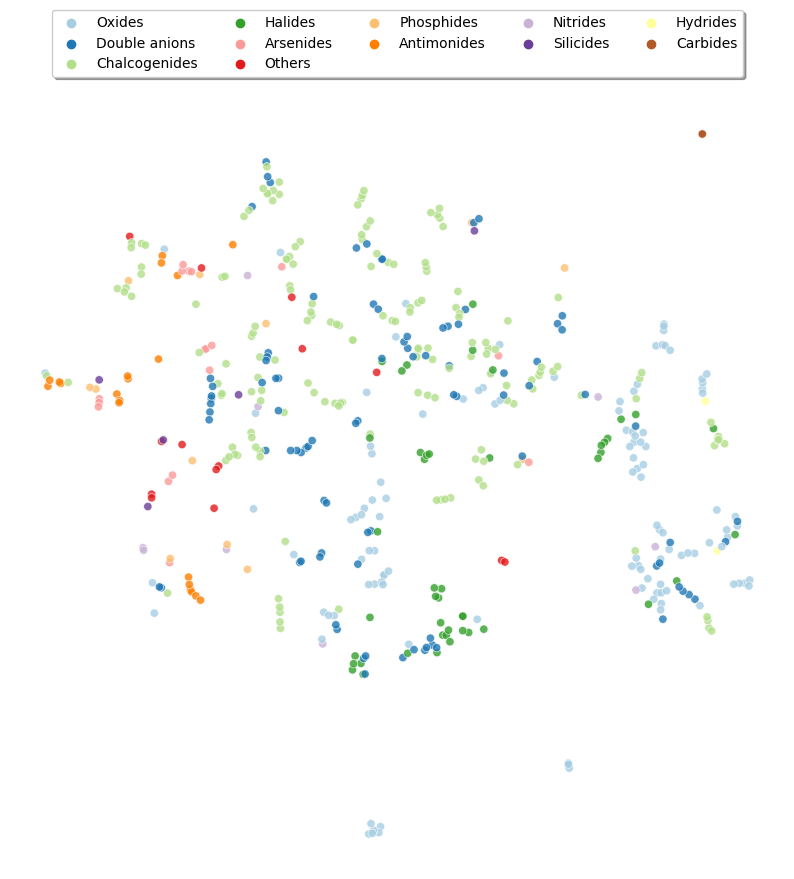

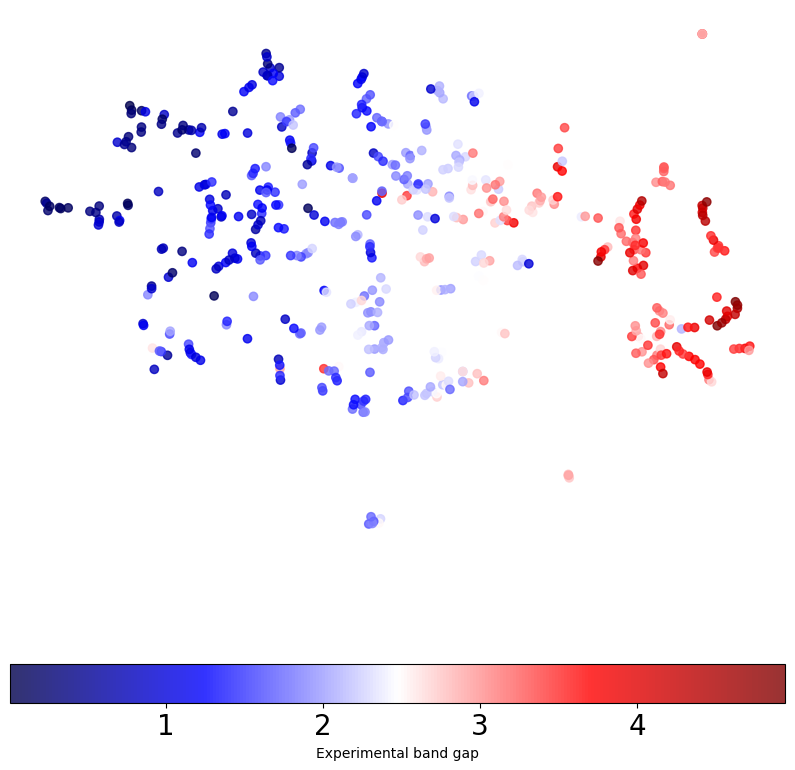

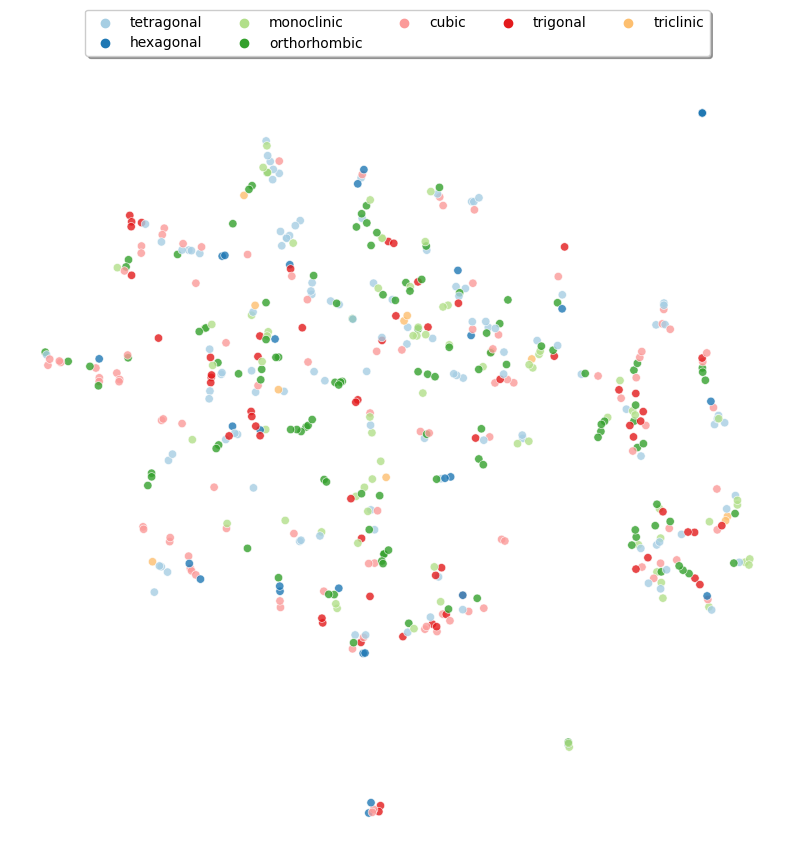

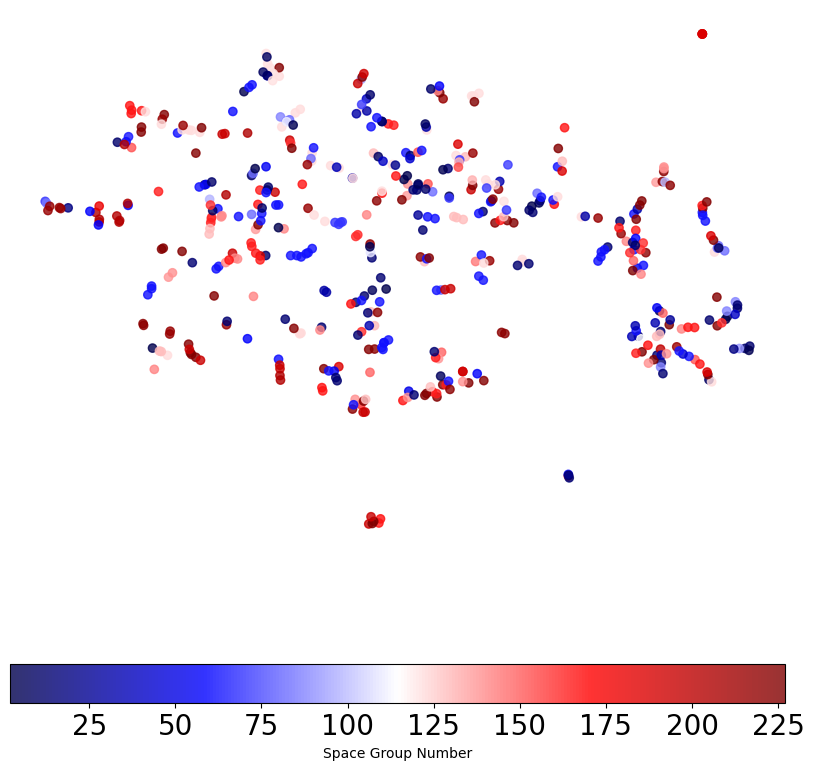

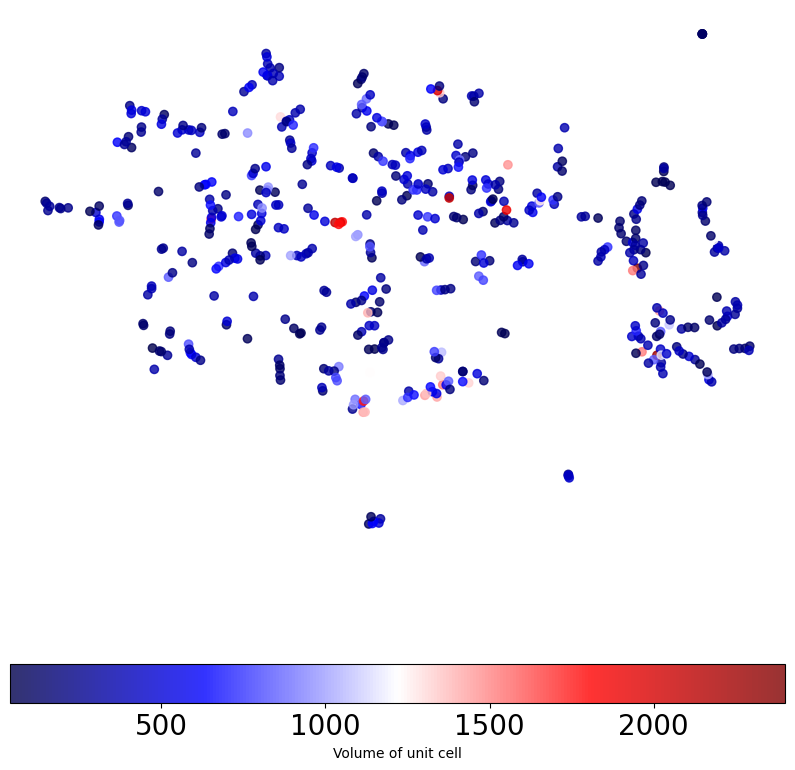

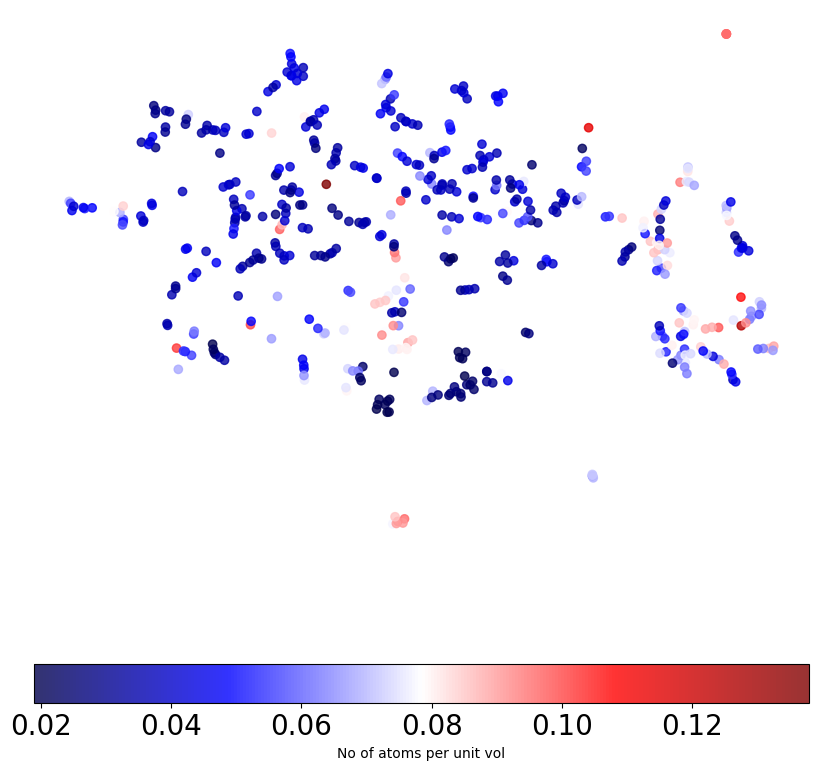

In [10]:
#Plot mat type
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="mat_type",
    palette=sns.color_palette("Paired", len(input_dataset['mat_type'].unique())),
    data=input_dataset,
    alpha=0.8,
    #legend = False
)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')

###plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(loc='lower center', bbox_to_anchor=(0,1.02, 1,0.2), fancybox=True, shadow=True, ncol=5)

plt.show()
#plt.savefig('tsne_mattype.png', dpi = 300, bbox_inches = 'tight')
plt.close('all')

#Plot BG
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.bg_exp, cmap = 'seismic')

plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('Experimental band gap')
for t in cbar.ax.get_xticklabels():
      t.set_fontsize(20)

plt.show()
plt.close('all')

#Plot Crystal System
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="CS",
    palette=sns.color_palette("Paired", len(input_dataset['CS'].unique())),
    data=input_dataset,
    alpha=0.8,
    #legend = False
)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')

###plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(loc='lower center', bbox_to_anchor=(0,1.02, 1,0.2), fancybox=True, shadow=True, ncol=5)
plt.show()
plt.close('all')

#Plot SG
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.SG, cmap = 'seismic')
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('Space Group Number')
for t in cbar.ax.get_xticklabels():
       t.set_fontsize(20)
plt.show()
plt.close('all')

#Plot V
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.V, cmap = 'seismic')
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('Volume of unit cell')
for t in cbar.ax.get_xticklabels():
       t.set_fontsize(20)
plt.show()
plt.close('all')

#Plot NAV
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.NAV, cmap = 'seismic')
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('No of atoms per unit vol')
for t in cbar.ax.get_xticklabels():
       t.set_fontsize(20)
plt.show()
plt.close('all')

Applying the learnt embedding to DS3

Loading model
=> loaded model (epoch 250, validation 0.39866510033607483)
Test: [0/1]	Time 0.086 (0.086)	Loss 2.9584 (2.9584)	MAE 2.200 (2.200)
 ** MAE 2.200
MAE_val_main= 0.23336448001861576
Querying materials project --- This might take a few minutes


/home/hassan101/anaconda3/envs/cgcnn_matai/lib/python3.11/site-packages/pymatgen/io/cif.py:1165: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


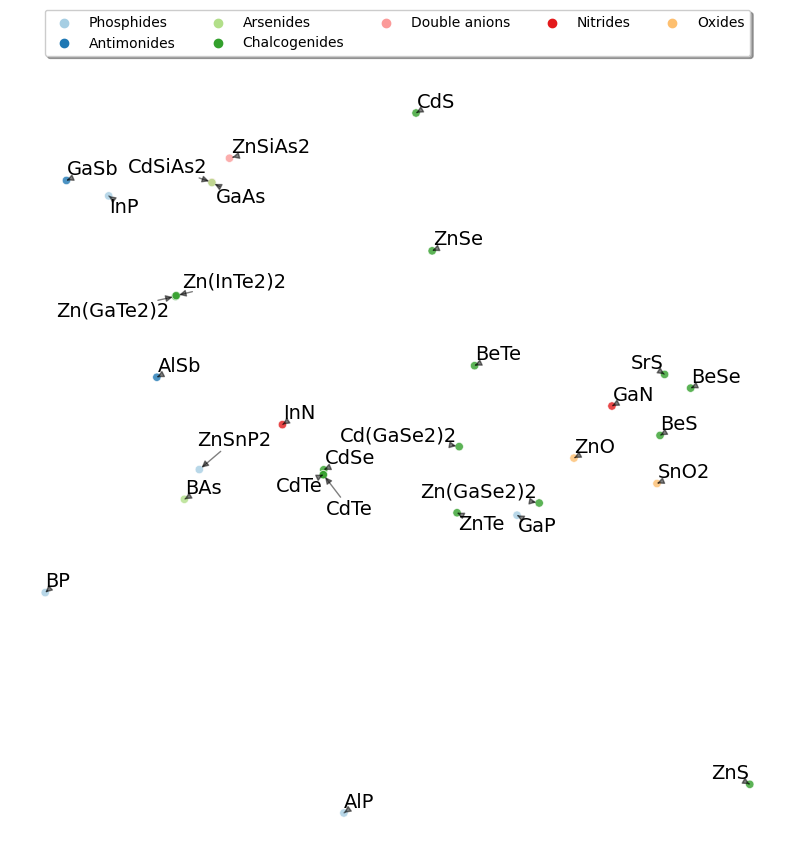

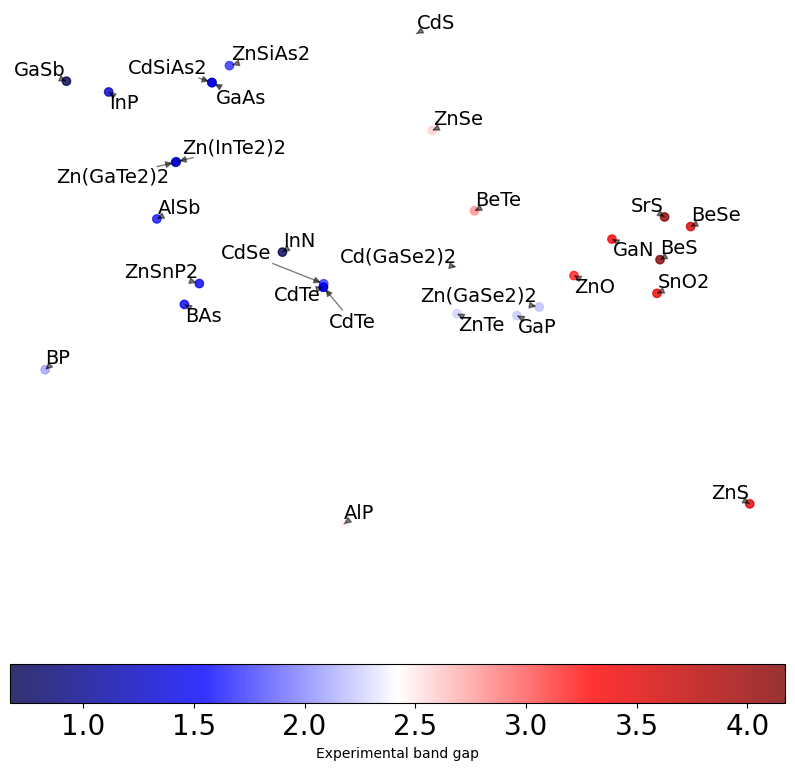

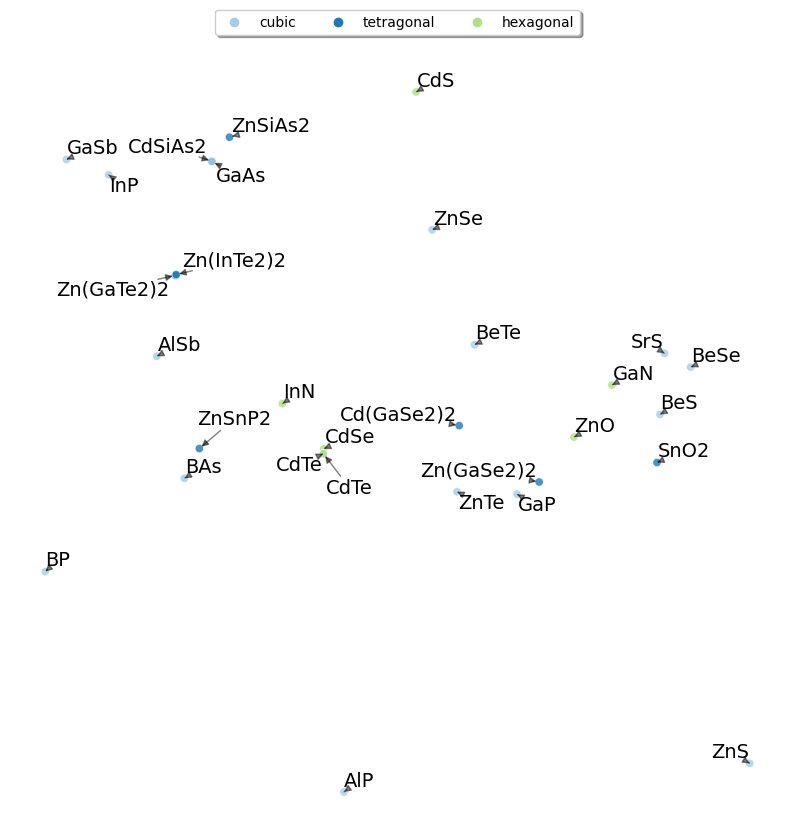

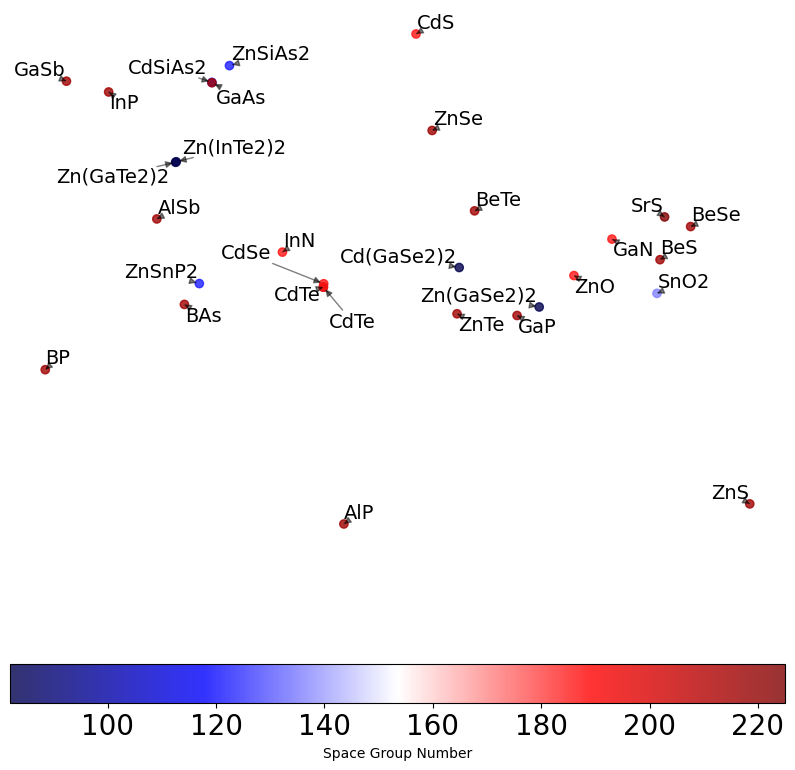

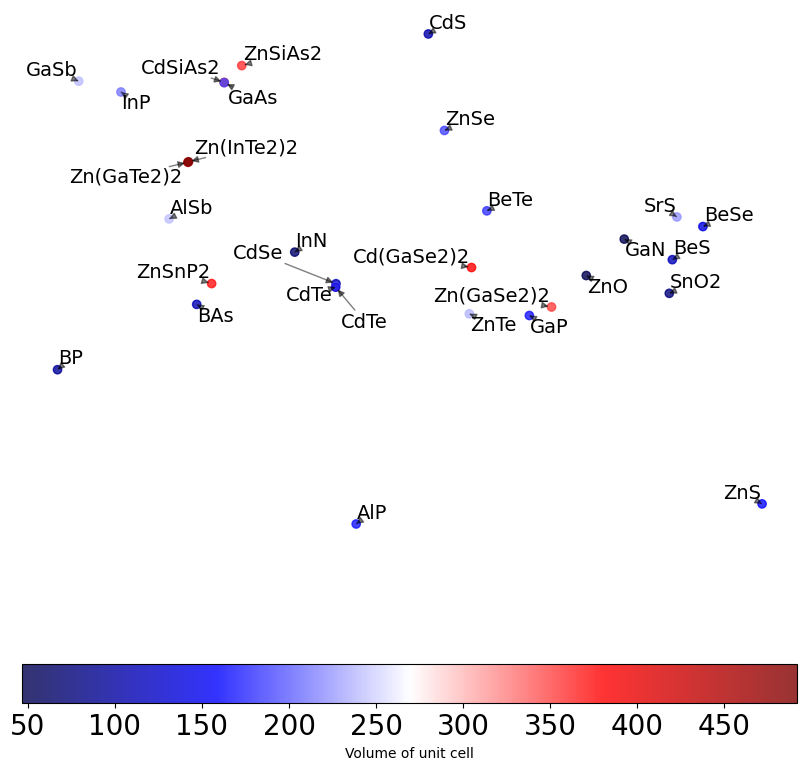

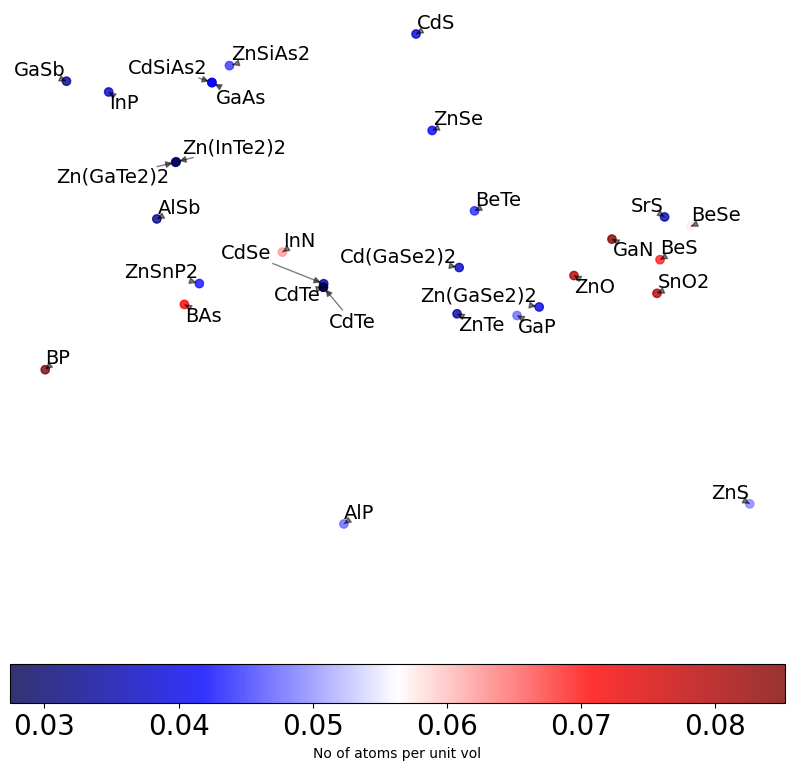

In [11]:
input_dataset, crystal_features = populate(df_ds3)

tsne_results = embedding.transform(crystal_features)

input_dataset['tsne_1'] = tsne_results[:,0]
input_dataset['tsne_2'] = tsne_results[:,1]

#Plot mat type
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="mat_type",
    palette=sns.color_palette("Paired", len(input_dataset['mat_type'].unique())),
    data=input_dataset,
    alpha=0.8,
    #legend = False
)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')

###plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(loc='lower center', bbox_to_anchor=(0,1.02, 1,0.2), fancybox=True, shadow=True, ncol=5)

from adjustText import adjust_text
texts = []
for x, y, text in zip(input_dataset['tsne_1'], input_dataset['tsne_2'], input_dataset['formula']):
    texts.append(plt.text(x, y, text,size=14))
adjust_text(texts, force_text=1, arrowprops=dict(arrowstyle="-|>",
                                                    color='k', alpha=0.5))

plt.show()
plt.close('all')

#Plot BG
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.bg_exp, cmap = 'seismic')

plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('Experimental band gap')
for t in cbar.ax.get_xticklabels():
      t.set_fontsize(20)

from adjustText import adjust_text
texts = []
for x, y, text in zip(input_dataset['tsne_1'], input_dataset['tsne_2'], input_dataset['formula']):
    texts.append(plt.text(x, y, text,size=14))
adjust_text(texts, force_text=1, arrowprops=dict(arrowstyle="-|>",
                                                    color='k', alpha=0.5))
plt.show()
plt.close('all')

#Plot Crystal System
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="CS",
    palette=sns.color_palette("Paired", len(input_dataset['CS'].unique())),
    data=input_dataset,
    alpha=0.8,
    #legend = False
)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')

###plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(loc='lower center', bbox_to_anchor=(0,1.02, 1,0.2), fancybox=True, shadow=True, ncol=5)
for t in cbar.ax.get_xticklabels():
      t.set_fontsize(20)

from adjustText import adjust_text
texts = []
for x, y, text in zip(input_dataset['tsne_1'], input_dataset['tsne_2'], input_dataset['formula']):
    texts.append(plt.text(x, y, text,size=14))
adjust_text(texts, force_text=1, arrowprops=dict(arrowstyle="-|>",
                                                    color='k', alpha=0.5))
plt.show()
plt.close('all')

#Plot SG
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.SG, cmap = 'seismic')
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('Space Group Number')
for t in cbar.ax.get_xticklabels():
       t.set_fontsize(20)
from adjustText import adjust_text
texts = []
for x, y, text in zip(input_dataset['tsne_1'], input_dataset['tsne_2'], input_dataset['formula']):
    texts.append(plt.text(x, y, text,size=14))
adjust_text(texts, force_text=1, arrowprops=dict(arrowstyle="-|>",
                                                    color='k', alpha=0.5))       
plt.show()
plt.close('all')

#Plot V
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.V, cmap = 'seismic')
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('Volume of unit cell')
for t in cbar.ax.get_xticklabels():
       t.set_fontsize(20)
texts = []
for x, y, text in zip(input_dataset['tsne_1'], input_dataset['tsne_2'], input_dataset['formula']):
    texts.append(plt.text(x, y, text,size=14))
adjust_text(texts, force_text=1, arrowprops=dict(arrowstyle="-|>",
                                                    color='k', alpha=0.5))   
plt.show()
plt.close('all')

#Plot NAV
plt.figure(figsize=(10,10))
plt.scatter(input_dataset.tsne_1, input_dataset.tsne_2, alpha = .8, c = input_dataset.NAV, cmap = 'seismic')
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.axis('off')
cbar = plt.colorbar(location="bottom")
cbar.set_label('No of atoms per unit vol')
for t in cbar.ax.get_xticklabels():
       t.set_fontsize(20)
texts = []
for x, y, text in zip(input_dataset['tsne_1'], input_dataset['tsne_2'], input_dataset['formula']):
    texts.append(plt.text(x, y, text,size=14))
adjust_text(texts, force_text=1, arrowprops=dict(arrowstyle="-|>",
                                                    color='k', alpha=0.5))   
plt.show()
plt.close('all')